In [106]:
import torch 
import torch.nn.functional as F
from torch import nn
from collections import OrderedDict

# multihead self-attention implementation
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, h, use_enc_embed=False, use_mask=False, mask=None):
        super().__init__()
        self.encode = 0
        self.h = h
        self.W_O = nn.Parameter(torch.rand(h*d_v, d_model))
        self.attn = nn.ModuleList([ScaledDotProductAttention(d_model, d_k, d_v, use_enc_embed=use_enc_embed, use_mask=use_mask, mask=mask) for _ in range(h)])
        self.d_v = d_v

    def forward(self, x, enc_embed=None):
        attn_out = torch.zeros((x.shape[0], x.shape[1], self.d_v*self.h))

        for i in range(self.h):
            attn_out[:, :, i*self.d_v:(i+1)*self.d_v] = self.attn[i](x, enc_embed)

        return attn_out @ self.W_O
    
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, use_enc_embed=False, use_mask=False, mask=None):
        super().__init__()
        self.W_Q = nn.Parameter(torch.rand((d_model, d_k)))
        self.W_K = nn.Parameter(torch.rand((d_model, d_k)))
        self.W_V = nn.Parameter(torch.rand(d_model, d_v))

        nn.init.xavier_normal_(self.W_Q)
        nn.init.xavier_normal_(self.W_K)
        nn.init.xavier_normal_(self.W_V)

        self.d_k = d_k
        self.use_mask = use_mask
        self.mask = mask
        self.use_enc_embed = use_enc_embed

    def forward(self, x, enc_embed):
        if self.use_enc_embed: 
            v = torch.matmul(enc_embed, self.W_V)
            k = torch.matmul(enc_embed, self.W_K)
        else:
            k = torch.matmul(x, self.W_K)
            v = torch.matmul(x, self.W_V)
        
        q = torch.matmul(x, self.W_Q)

        if self.use_mask:
            mask = nn.Transformer.generate_square_subsequent_mask(q.shape[1])
            weights = F.softmax(mask + torch.matmul(q, torch.permute(k, (0, 2, 1)))/torch.sqrt(torch.tensor(self.d_k)), dim=-1)
            return weights @ v
        else:
            return F.softmax(torch.matmul(q, torch.permute(k, (0, 2, 1)))/torch.sqrt(torch.tensor(self.d_k)), dim=-1) @ v

In [107]:
# component testing against pytorch implementations
# 1. test that our multihead attention implementation is correct (at least for encoder without masking)

# test 1 - with 1 head 
pt_attn = nn.MultiheadAttention(embed_dim=512, num_heads=1, bias=False, batch_first = True) # pytorch implementation
input = torch.rand((1, 8, 512))
pt_attn_output, pt_attn_weights = pt_attn(input, input, input)

my_attn = MultiHeadedAttention(512, 512, 512, 1, use_enc_embed=False, use_mask=False, mask=None) # my implementation
my_attn.attn[0].W_Q = nn.Parameter(pt_attn.in_proj_weight[:512, :].T) # use same parameter values
my_attn.attn[0].W_K = nn.Parameter(pt_attn.in_proj_weight[512:2*512, :].T)
my_attn.attn[0].W_V = nn.Parameter(pt_attn.in_proj_weight[2*512:3*512, :].T)
my_attn.W_O = nn.Parameter(pt_attn.out_proj.weight.T)
my_attn_output = my_attn(input)

assert(torch.allclose(my_attn_output, pt_attn_output, atol=1e-5, rtol=1e-5))

# test 2 - with 2 heads 
pt_attn = nn.MultiheadAttention(embed_dim=512, num_heads=2, bias=False, batch_first = True) # pytorch implementation
input = torch.rand((1, 8, 512))
pt_attn_output, pt_attn_weights = pt_attn(input, input, input)

my_attn = MultiHeadedAttention(512, 256, 256, 2, use_enc_embed=False, use_mask=False, mask=None) # my implementation

my_attn.attn[0].W_Q = nn.Parameter(pt_attn.in_proj_weight[:256, :].T) # use same parameter values
my_attn.attn[1].W_Q = nn.Parameter(pt_attn.in_proj_weight[256:2*256, :].T)

my_attn.attn[0].W_K = nn.Parameter(pt_attn.in_proj_weight[2*256:3*256, :].T)
my_attn.attn[1].W_K = nn.Parameter(pt_attn.in_proj_weight[3*256:4*256, :].T) # use same parameter values

my_attn.attn[0].W_V = nn.Parameter(pt_attn.in_proj_weight[4*256:5*256, :].T)
my_attn.attn[1].W_V = nn.Parameter(pt_attn.in_proj_weight[5*256:6*256, :].T)

my_attn.W_O = nn.Parameter(pt_attn.out_proj.weight.T)
my_attn_output = my_attn(input)

assert(torch.allclose(my_attn_output, pt_attn_output, atol=1e-3, rtol=1e-3))

In [108]:
# positional encoder implementation
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, input_len):
        super().__init__()
        self.input_len = input_len
        self.d_model = d_model
        
    def forward(self):
        pos = torch.zeros(self.d_model, self.input_len)

        for i in range(int(self.input_len/2)):
            pos[:, 2*i] = torch.sin(torch.range(start=0, end=self.d_model-1, step=1)/(10000 ** (2*i/self.input_len)))
            pos[:, 2*i+1] = torch.cos(torch.range(start=1, end=self.d_model, step=1)/(10000 ** (2*i/self.input_len)))
        return pos

/var/folders/j8/f15cwy8d2y997yr276w5nd6m0000gn/T/ipykernel_60591/1624865870.py:12: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  pos[:, 2*i] = torch.sin(torch.range(start=0, end=self.d_model-1, step=1)/(10000 ** (2*i/self.input_len)))
/var/folders/j8/f15cwy8d2y997yr276w5nd6m0000gn/T/ipykernel_60591/1624865870.py:13: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  pos[:, 2*i+1] = torch.cos(torch.range(start=1, end=self.d_model, step=1)/(10000 ** (2*i/self.input_len)))


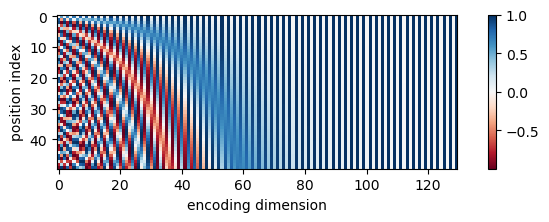

In [109]:
# visualize positional encoding as sanity check 
# confirm that matches other peoples plots - e.g., https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
import matplotlib.pyplot as plt
pos_enc = PositionalEncoder(50, 130)

plt.figure(figsize=(8,2))
plt.imshow(pos_enc(), cmap='RdBu')
plt.xlabel('encoding dimension')
plt.ylabel('position index')
plt.colorbar()
plt.show()

In [110]:
# transformer encoder layer implementation
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_k=4, d_v=4, n_heads=4, d_ff = 128):
        super().__init__()
        self.d_model = d_model
        self.mha = MultiHeadedAttention(d_model, d_k, d_v, n_heads)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_norm1(x + self.mha(x))
        x = self.layer_norm2(x + self.linear2(self.relu(self.linear1(x))))
        return x

In [111]:
# component testing against pytorch implementations
pt_encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=1, dim_feedforward=2048, dropout=0, batch_first=True)
input = torch.rand(1, 8, 512)
pt_enc_out = pt_encoder_layer(input)

my_encoder_layer = EncoderLayer(512, d_k=512, d_v=512, n_heads=1, d_ff=2048) # my implementation

# transfer multiheaded attention parameters to my layer
my_encoder_layer.mha.attn[0].W_Q = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[:512, :].T) # use same parameter values
my_encoder_layer.mha.attn[0].W_K = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[512:2*512, :].T)
my_encoder_layer.mha.attn[0].W_V = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[2*512:3*512, :].T)
my_encoder_layer.mha.W_O = nn.Parameter(pt_encoder_layer.self_attn.out_proj.weight.T)

# transfer linear layer parameters to my layer
my_encoder_layer.linear1.weight = nn.Parameter(pt_encoder_layer.linear1.weight)
my_encoder_layer.linear1.bias = nn.Parameter(pt_encoder_layer.linear1.bias)

my_encoder_layer.linear2.weight = nn.Parameter(pt_encoder_layer.linear2.weight)
my_encoder_layer.linear2.bias = nn.Parameter(pt_encoder_layer.linear2.bias)

my_enc_out = my_encoder_layer(input)

assert(torch.allclose(my_enc_out, pt_enc_out, atol=1e-3, rtol=1e-3))

In [112]:
# transformer decoder layer implementation
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_k=4, d_v=4, h=4, d_ff = 128, use_mask=False):
        super().__init__()
        self.d_model = d_model
        self.mmha = MultiHeadedAttention(d_model, d_k, d_v, h, use_mask=use_mask, mask=1)
        self.mha = MultiHeadedAttention(d_model, d_k, d_v, h, use_enc_embed=True)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.layer_norm3 = nn.LayerNorm(d_model)

    def forward(self, target, memory):
        x = self.layer_norm1(target + self.mmha(target))
        x = self.layer_norm2(x + self.mha(x, memory))
        x = self.layer_norm3(x + self.linear2(self.relu(self.linear1(x))))
        return x

In [113]:
# component testing against pytorch implementations
# test 1 - transformer decoder without causal masking
pt_decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=1, dim_feedforward=2048, dropout=0, batch_first=True, bias=True)

memory = torch.rand(1, 8, 512)
target = torch.rand(1, 8, 512)
pt_dec_out = pt_decoder_layer(target, memory) #, tgt_mask = nn.Transformer.generate_square_subsequent_mask(8), tgt_is_causal=True)

my_decoder_layer = DecoderLayer(512, d_k=512, d_v=512, h=1, d_ff=2048) # my implementation

# transfer masked multiheaded attention parameters to my layer
my_decoder_layer.mmha.attn[0].W_Q = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[:512, :].T) # use same parameter values
my_decoder_layer.mmha.attn[0].W_K = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[512:2*512, :].T)
my_decoder_layer.mmha.attn[0].W_V = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[2*512:3*512, :].T)
my_decoder_layer.mmha.W_O = nn.Parameter(pt_decoder_layer.self_attn.out_proj.weight.T)

# transfer multiheaded attention parameters to my layer
my_decoder_layer.mha.attn[0].W_Q = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[:512, :].T) # use same parameter values
my_decoder_layer.mha.attn[0].W_K = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[512:2*512, :].T)
my_decoder_layer.mha.attn[0].W_V = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[2*512:3*512, :].T)
my_decoder_layer.mha.W_O = nn.Parameter(pt_decoder_layer.multihead_attn.out_proj.weight.T)

# transfer linear layer parameters to my layer
my_decoder_layer.linear1.weight = nn.Parameter(pt_decoder_layer.linear1.weight)
my_decoder_layer.linear1.bias = nn.Parameter(pt_decoder_layer.linear1.bias)

my_decoder_layer.linear2.weight = nn.Parameter(pt_decoder_layer.linear2.weight)
my_decoder_layer.linear2.bias = nn.Parameter(pt_decoder_layer.linear2.bias)

my_dec_out = my_decoder_layer(target, memory)

assert(torch.allclose(my_dec_out, pt_dec_out, atol=1e-3, rtol=1e-3))

# test 2 - transformer decoder with causal masking
pt_dec_out = pt_decoder_layer(target, memory, tgt_mask = nn.Transformer.generate_square_subsequent_mask(8), tgt_is_causal=True)
my_decoder_layer.mmha.attn[0].use_mask = True

my_dec_out = my_decoder_layer(target, memory)

assert(torch.allclose(my_dec_out, pt_dec_out, atol=1e-3, rtol=1e-3))

In [114]:
# put all the separate components together to make the transformer
class Transformer(nn.Module):
    def __init__(self, n_encoder = 6, n_decoder = 6, d_model = 16, n_heads = 2, seq_len = 10):
        super().__init__()
        self.encoder = nn.ModuleList([EncoderLayer(d_model, d_v=int(d_model/n_heads), d_k=int(d_model/n_heads), d_ff=2048, n_heads=n_heads) for i in range(n_encoder)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, d_v=int(d_model/n_heads), d_k=int(d_model/n_heads), d_ff=2048, h=n_heads) for i in range(n_decoder)])
        self.pos_encoder = PositionalEncoder(seq_len, d_model)
        self.seq_len = seq_len
        self.n_decoder = n_decoder
        self.n_encoder = n_encoder
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, input, target):
        memory = input + self.pos_encoder()
        for i in range(self.n_encoder):
            memory = self.encoder[i](memory)

        memory = self.layer_norm1(memory)
        
        x = target + self.pos_encoder()
        for i in range(self.n_decoder):
            x = self.decoder[i](x, memory)
        x = self.layer_norm2(x)

        return x

In [115]:
pt_transformer = nn.Transformer(batch_first=True, dropout=0, nhead=1)

input = torch.rand((1, 8, 512))
target = torch.rand((1, 8, 512))

pos_enc = PositionalEncoder(8, 512)

pt_out = pt_transformer(input + pos_enc(), target + + pos_enc())

my_transformer = Transformer(d_model=512, n_heads=1, seq_len = 8)

# for each encoder layer transfer parameters
for i in range(6):
    my_encoder_layer = my_transformer.encoder[i]
    pt_encoder_layer = pt_transformer.encoder.layers[i]

    my_encoder_layer.mha.attn[0].W_Q = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[:512, :].T) # use same parameter values
    my_encoder_layer.mha.attn[0].W_K = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[512:2*512, :].T)
    my_encoder_layer.mha.attn[0].W_V = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[2*512:3*512, :].T)
    my_encoder_layer.mha.W_O = nn.Parameter(pt_encoder_layer.self_attn.out_proj.weight.T)

    # transfer linear layer parameters to my layer
    my_encoder_layer.linear1.weight = nn.Parameter(pt_encoder_layer.linear1.weight)
    my_encoder_layer.linear1.bias = nn.Parameter(pt_encoder_layer.linear1.bias)

    my_encoder_layer.linear2.weight = nn.Parameter(pt_encoder_layer.linear2.weight)
    my_encoder_layer.linear2.bias = nn.Parameter(pt_encoder_layer.linear2.bias)
    
# for each decoder layer transfer parameters
for i in range(6):
    my_decoder_layer = my_transformer.decoder[i]
    pt_decoder_layer = pt_transformer.decoder.layers[i]

    # transfer masked multiheaded attention parameters to my layer
    my_decoder_layer.mmha.attn[0].W_Q = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[:512, :].T) # use same parameter values
    my_decoder_layer.mmha.attn[0].W_K = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[512:2*512, :].T)
    my_decoder_layer.mmha.attn[0].W_V = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[2*512:3*512, :].T)
    my_decoder_layer.mmha.W_O = nn.Parameter(pt_decoder_layer.self_attn.out_proj.weight.T)

    # transfer multiheaded attention parameters to my layer
    my_decoder_layer.mha.attn[0].W_Q = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[:512, :].T) # use same parameter values
    my_decoder_layer.mha.attn[0].W_K = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[512:2*512, :].T)
    my_decoder_layer.mha.attn[0].W_V = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[2*512:3*512, :].T)
    my_decoder_layer.mha.W_O = nn.Parameter(pt_decoder_layer.multihead_attn.out_proj.weight.T)

    # transfer linear layer parameters to my layer
    my_decoder_layer.linear1.weight = nn.Parameter(pt_decoder_layer.linear1.weight)
    my_decoder_layer.linear1.bias = nn.Parameter(pt_decoder_layer.linear1.bias)

    my_decoder_layer.linear2.weight = nn.Parameter(pt_decoder_layer.linear2.weight)
    my_decoder_layer.linear2.bias = nn.Parameter(pt_decoder_layer.linear2.bias)

my_out = my_transformer(input, target)

assert torch.allclose(my_out, pt_out, atol=1e-3, rtol=1e-3)

/Users/ethantrepka/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/var/folders/j8/f15cwy8d2y997yr276w5nd6m0000gn/T/ipykernel_60591/1624865870.py:12: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  pos[:, 2*i] = torch.sin(torch.range(start=0, end=self.d_model-1, step=1)/(10000 ** (2*i/self.input_len)))
/var/folders/j8/f15cwy8d2y997yr276w5nd6m0000gn/T/ipykernel_60591/1624865870.py:13: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.aran

In [116]:
# selective copying task to test the model
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

def generate_selective_copying_data(num_samples):
    vocab_size = 16
    seq_len = 64
    num_data_tokens = 64 #16

    data = np.random.randint(1, vocab_size, size=(num_samples, num_data_tokens))

    inputs = np.zeros((num_samples, seq_len), dtype=int)
    targets = np.zeros((num_samples, seq_len), dtype=int)

    for i in range(num_samples):
        indices = (np.random.permutation(seq_len)[:num_data_tokens])
        indices = np.sort(indices)

        inputs[i, indices] = data[i]
        targets[i, :num_data_tokens] = data[i]

    return inputs, targets

class SelectiveCopyingDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = F.one_hot(torch.tensor(inputs, dtype=torch.long))
        self.targets = F.one_hot(torch.tensor(targets, dtype=torch.long))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.permute(self.targets[idx], (0, 1)), torch.permute(self.targets[idx], (0, 1)) #  torch.permute(self.inputs[idx], (0, 1)),
    
def create_dataloader(inputs, targets, batch_size):
    dataset = SelectiveCopyingDataset(inputs, targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

inputs, targets = generate_selective_copying_data(1000)
dataloader = create_dataloader(inputs, targets, batch_size=32)

In [117]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

n_encoder = 6
n_decoder = 6
d_model = 16
seq_len = 64
model = Transformer(n_encoder=n_encoder, n_decoder=n_decoder, d_model=d_model, seq_len=seq_len, n_heads=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [118]:
num_epochs = 30

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data, target)

        loss = loss_fn(output, target.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")

/var/folders/j8/f15cwy8d2y997yr276w5nd6m0000gn/T/ipykernel_60591/1624865870.py:12: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  pos[:, 2*i] = torch.sin(torch.range(start=0, end=self.d_model-1, step=1)/(10000 ** (2*i/self.input_len)))
/var/folders/j8/f15cwy8d2y997yr276w5nd6m0000gn/T/ipykernel_60591/1624865870.py:13: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  pos[:, 2*i+1] = torch.cos(torch.range(start=1, end=self.d_model, step=1)/(10000 ** (2*i/self.input_len)))


Epoch 1, Loss: 0.6934901177883148
Epoch 2, Loss: 0.5376590006053448
Epoch 3, Loss: 0.38892438914626837
Epoch 4, Loss: 0.3064762530848384
Epoch 5, Loss: 0.2695436030626297


KeyboardInterrupt: 

/var/folders/j8/f15cwy8d2y997yr276w5nd6m0000gn/T/ipykernel_60591/1624865870.py:12: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  pos[:, 2*i] = torch.sin(torch.range(start=0, end=self.d_model-1, step=1)/(10000 ** (2*i/self.input_len)))
/var/folders/j8/f15cwy8d2y997yr276w5nd6m0000gn/T/ipykernel_60591/1624865870.py:13: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  pos[:, 2*i+1] = torch.cos(torch.range(start=1, end=self.d_model, step=1)/(10000 ** (2*i/self.input_len)))


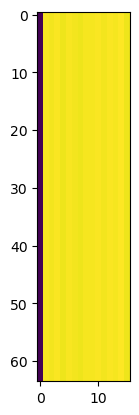

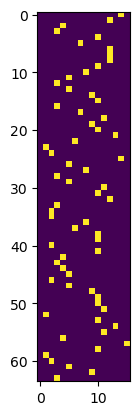

In [105]:
import matplotlib.pyplot as plt

output = model(data[1:2], target[1:2])

plt.imshow(torch.squeeze(torch.softmax(output, -1)).detach().numpy())
plt.imshow(torch.squeeze(output).detach().numpy())
plt.show()
plt.imshow(torch.squeeze(target[0]).detach().numpy())
plt.show()